In [85]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

In [86]:
input_filename = 'data/yields.parquet'
# load the data into a dataframe
df = pd.read_parquet(input_filename)
# df.head()

In [87]:
grouped_df = df.groupby(['time', 'County','year']).agg({'ndvi.landsat': 'mean', 'Yield (Bu/Acre)': 'mean', 'Acres Planted':'mean'}).reset_index()
print(f'Number of rows in df: {len(df):,}')
print(f'Number of rows in grouped_df: {len(grouped_df):,}')
grouped_df.head()

Number of rows in df: 8,401,661
Number of rows in grouped_df: 776,522


,time,County,year,ndvi.landsat,Yield (Bu/Acre),Acres Planted
0,2013-03-18,COLORADO/ADAMS,2013,0.303621,27.5,153000.0
1,2013-03-18,COLORADO/MORGAN,2013,0.272985,36.5,55800.0
2,2013-03-18,COLORADO/WELD,2013,0.202855,29.5,134500.0
3,2013-03-18,NEBRASKA/BANNER,2013,0.198277,23.2,58200.0
4,2013-03-18,NEBRASKA/BOX BUTTE,2013,0.259546,51.2,110600.0


In [127]:
CUT_OFF_MONTH = 6 # use no data after June 30
YEARS_CUT_OFF = 6
R_CUT_OFF = 0.0
grouped_df1 = grouped_df[(grouped_df['time'].dt.month < CUT_OFF_MONTH)]
max_ndvi_idx = grouped_df1.groupby(['County','year'])['ndvi.landsat'].idxmax()
max_ndvi_df = grouped_df1.loc[max_ndvi_idx, ['year','County','ndvi.landsat', 'Yield (Bu/Acre)', 'Acres Planted']]

In [128]:
def getR2(county):
    y = max_ndvi_df[max_ndvi_df['County'] == county]
    X = sm.add_constant(y['ndvi.landsat'])
    model = sm.OLS(y['Yield (Bu/Acre)'], X)
    results = model.fit()
    return results.rsquared

In [129]:
counties = max_ndvi_df['County'].unique()
good_counties = []
for county in counties:
    row_count = max_ndvi_df[max_ndvi_df['County'] == county].shape[0]
    if row_count < YEARS_CUT_OFF:
        continue
#     print(row_count)
    r2 = getR2(county)
    if r2 > R_CUT_OFF:
        good_counties.append(county)
        # print(f'{county}: {r2}')

# len(good_counties) 

In [130]:
subset_df = max_ndvi_df[max_ndvi_df['County'].isin(good_counties)]

In [131]:
def do_county(county):
    y = max_ndvi_df[max_ndvi_df['County'] == county]
    # Perform linear regression
    X = sm.add_constant(y['ndvi.landsat'])
    model = sm.OLS(y['Yield (Bu/Acre)'], X)
    results = model.fit()
    # Create a new DataFrame with additional columns
    new_df = y.copy()
    new_df['alpha'] = results.params[0]
    new_df['beta'] = results.params[1]
    new_df['r2'] = results.rsquared
    new_df['fitted'] = results.params[0] + results.params[1] * new_df['ndvi.landsat']
    new_df['error'] = new_df['fitted'] - new_df['Yield (Bu/Acre)']
    return new_df


x = []
for county in good_counties:
    x.append(do_county(county))

final = pd.concat(x)
sum(final['error'])

2.1742607714259066e-12

In [132]:
final['actual_harvest'] = final['Acres Planted'] * final['Yield (Bu/Acre)']
final['fitted_harvest'] = final['Acres Planted'] * final['fitted']
# final.head()

grouped_final = final.groupby(['year']).agg({'actual_harvest':'sum', 'fitted_harvest':'sum', 'Acres Planted':'sum'})
grouped_final['actual_yield'] = grouped_final['actual_harvest'] / grouped_final['Acres Planted']
grouped_final['fitted_yield'] = grouped_final['fitted_harvest'] / grouped_final['Acres Planted']
grouped_final['error'] = grouped_final['fitted_yield'] - grouped_final['actual_yield']
grouped_final['%error'] = grouped_final['error'] / grouped_final['actual_yield'] * 100.0

print(f'MAPE: {grouped_final["%error"].abs().mean()}')
print(f'RMS: {np.sqrt(np.mean(grouped_final["error"] ** 2))}')
grouped_final.head(12)

MAPE: 6.601520295526505
RMS: 2.986369463731277


,actual_harvest,fitted_harvest,Acres Planted,actual_yield,fitted_yield,error,%error
year,,,,,,,
2013,8.437750e+08,8.830605e+08,22761700.0,37.069945,38.795893,1.725948,4.655924
2014,7.923113e+08,8.990847e+08,24490000.0,32.352442,36.712321,4.359879,13.476197
2015,8.784969e+08,9.964692e+08,24043100.0,36.538422,41.445122,4.906700,13.428878
2016,1.080656e+09,1.007353e+09,21783600.0,49.608703,46.243630,-3.365073,-6.783232
2017,8.606979e+08,8.431188e+08,19214100.0,44.795119,43.880211,-0.914908,-2.042428
2018,7.335678e+08,7.177273e+08,17623700.0,41.623938,40.725121,-0.898816,-2.159373
2019,8.365784e+08,7.727524e+08,17138900.0,48.811673,45.087628,-3.724045,-7.629415
2020,9.059573e+08,8.445157e+08,19896600.0,45.533270,42.445228,-3.088042,-6.781947
2021,7.591820e+08,7.227401e+08,18011700.0,42.149382,40.126145,-2.023237,-4.800159


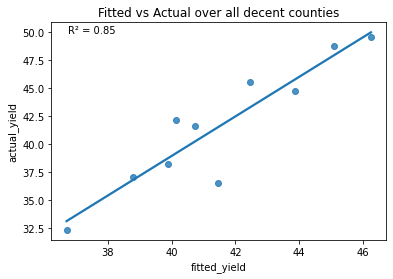

In [133]:
sns.regplot(x='fitted_yield', y='actual_yield', data=grouped_final,ci=None)
plt.annotate(f"R² = {round(grouped_final['actual_yield'].corr(grouped_final['fitted_yield'])**2, 2)}", xy=(0.05, 0.95), xycoords='axes fraction')
plt.title(f'Fitted vs Actual over all decent counties')
plt.show()